In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 10
TRAIN_SIZE  = 0.7
NOISE       = 0.0
MESH_SIZE   = 100

POPSIZE         = 200
MAX_STREE_DEPTH = 5
GENERATIONS     = 25
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

LIBSIZE      = 2000
LIB_MAXDEPTH = 3

RANDSTATE = 124

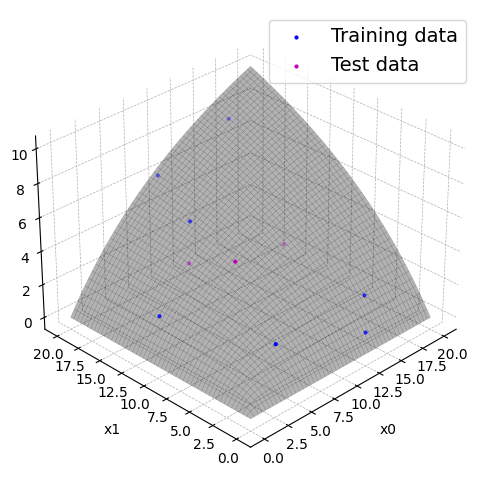

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

y_iqr = S_train.get_y_iqr()
solutionCreator = gp_creator.RandomSolutionCreator(nvars=S.nvars, y_iqr=y_iqr)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True, y_iqr=y_iqr),
      #gp.NumericParameterMutator(all=False, y_iqr=y_iqr)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, X_mesh, LIBSIZE, LIB_MAXDEPTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/24 [00:00<?, ?it/s]

         1384745 function calls (1167621 primitive calls) in 3.757 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4800    0.091    0.000    3.751    0.001 corrector.py:21(correct)
     4800    0.071    0.000    1.931    0.000 corrector.py:60(backprop_know)
     4784    0.048    0.000    1.082    0.000 library.py:496(cquery)
     4040    0.056    0.000    0.922    0.000 library.py:520(__local_cquery)
72048/15915    0.159    0.000    0.657    0.000 binop.py:27(__getitem__)
     4795    0.010    0.000    0.586    0.000 library.py:76(query)
     4795    0.293    0.000    0.576    0.000 _kdtree.py:363(query)
29334/9568    0.029    0.000    0.570    0.000 syntax_tree.py:139(pull_know_deriv)
16376/7316    0.340    0.000    0.544    0.000 binop.py:292(pull_know_deriv)
26797/11288    0.054    0.000    0.392    0.000 unaop.py:28(__getitem__)
14731/4800    0.015    0.000    0.313    0.000 syntax_tree.py:134(pull_know)
    1140

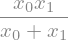

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

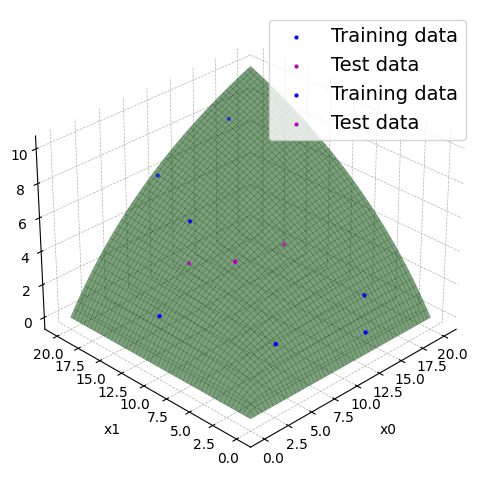

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

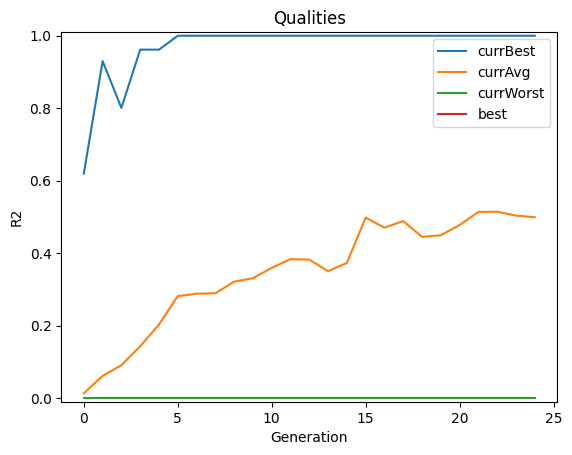

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

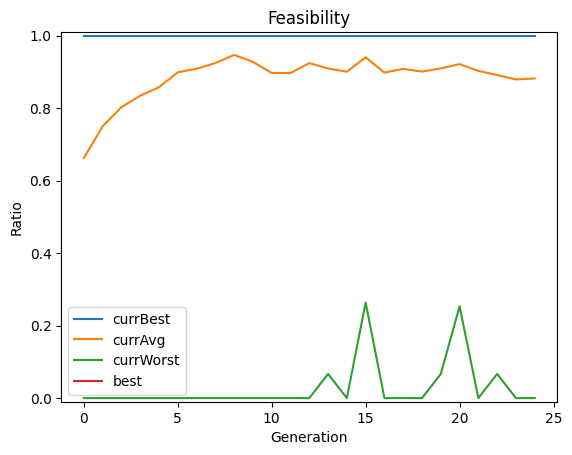

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

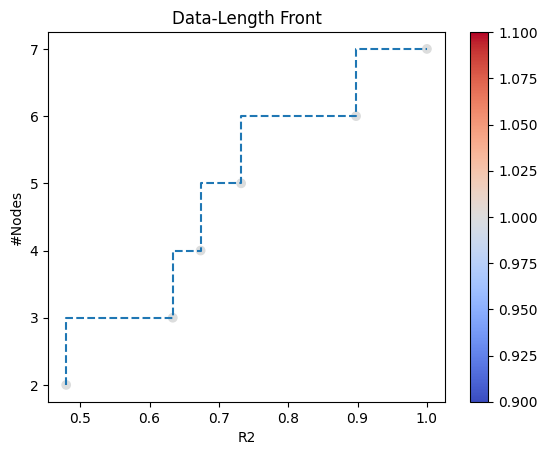

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,sqrt(x1),0,0.239857,0.479714,2,(sqrt),1,inf
1,1,(x0 / ((x1 + x0) / x1)),0,0.142857,1.000000,7,"(/, +)",1,inf
2,2,sqrt((x1 * (x0 * 0.16))),0,0.149636,0.897818,6,"(sqrt, *)",1,0.915040
3,3,((0.92 / 2.66) * x1),0,0.146406,0.732032,5,(*),1,0.830889
4,4,(x1 / 3.50),0,0.211148,0.633445,3,(),1,0.772715
5,5,sqrt((x1 + x1)),0,0.168408,0.673632,4,"(+, sqrt)",1,0.589487
6,0,sqrt(x0),1,0.014899,0.029799,2,(sqrt),1,inf
7,1,(x0 / ((x0 / x1) + (x0 / x0))),1,0.111111,1.000000,9,"(/, +)",1,inf
8,2,(x1 / 3.68),1,0.195256,0.585767,3,(),1,1.001616
9,3,exp(log(((0.92 / 2.66) * x1))),1,0.104576,0.732032,7,"(log, *, exp)",1,0.599418


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)